# Lane Boundary Projection

## Setting up Colab

In [ ]:
colab_nb = 'google.colab' in str(get_ipython())

In [ ]:
if colab_nb:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if colab_nb:
  %cd /content/drive/My Drive/aad/code/tests/lane_detection

## Introduction

In this exercise we will apply or knowledge of image formation to create label data for our deep learning model. To train that model we need lots of (input, output) examples. The inputs are images from a camera behind the wind shield of our vehicle. For the expected model output, we need to label each pixel in an image as being part of the left boundary, part of the right boundary, or neither of those.

Getting images is easy with Carla: We can attach a camera to a vehicle and store the image that this camera takes. If you want to see details, you can check out `collect_data.py`. Let's have a look at an exemplary image:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

(512, 1024, 3)

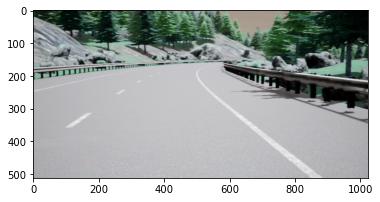

In [2]:
image_fn = str(Path("../../../data/Town04_Clear_Noon_09_09_2020_14_57_22_frame_625_validation_set.png"))
image = cv2.imread(image_fn)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image.shape

Each time the `collect_data.py` captures an image, it also writes down **[polylines](https://en.wikipedia.org/wiki/Polygonal_chain) in world coordinates** that represent the left and right lane boundary respectively. 

Zw-coords:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


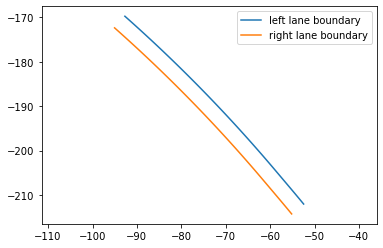

In [3]:
boundary_fn = image_fn.replace(".png", "_boundary.txt")
boundary_gt = np.loadtxt(boundary_fn)
# exploit that in the Carla world coordinates the road is mostly in the Xw-Yw plane
print("Zw-coords: ", boundary_gt[:,2])
plt.plot(boundary_gt[:,0], boundary_gt[:,1], label="left lane boundary")
plt.plot(boundary_gt[:,3], boundary_gt[:,4], label="right lane boundary")
plt.axis("equal")
plt.legend();

Now to get the label image, we need to take the world coordinates of the lane boundaries, transform them into the camera coordinate system, and then project them to image coordinates $(u,v)$ using the intrinsic matrix $K$.
The transformation from the world coordinate frame to the camera centered camera frame depends on the pose of the vehicle, to which the camera is attached. Carla makes it easy to obtain such transformation matrices, and we actually stored the transformation matrix corresponding to the image we are just looking at. Let's load it:

In [5]:
trafo_fn = image_fn.replace(".png", "_trafo.txt")
trafo_world_to_cam = np.loadtxt(trafo_fn)

In [14]:
trafo_world_to_cam

array([[-7.08870530e-01, -7.05338657e-01,  0.00000000e+00,
        -1.88616669e+02],
       [ 6.14743105e-02, -6.17821335e-02, -9.96194720e-01,
        -8.59588751e+00],
       [-7.02654646e-01,  7.06173079e-01, -8.71557370e-02,
         1.13167282e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Now we can project the polyline into our original image. This is where the exercise starts

## Exercise

Solve the TODO items in `exercises/lane_detection/camera_geometry.py` which are labeled as **"TODO step 1"**.

The cells below will help you check if your implementation is correct. You might want to read them before you start with your implementation.

### Unit test

In [32]:
# execute this cell to run unit tests on your implementation of step 1
%cd ../../../
!python -m code.tests.lane_detection.camera_geometry_unit_test 1
%cd -

/home/jjmachan/jjmachan/Algorithms-for-Automated-Driving
-------------------------
Running tests for step  1
-------------------------
Your function project_polyline seems to be correct!
Your function get_intrinsic_matrix seems to be correct!
/home/jjmachan/jjmachan/Algorithms-for-Automated-Driving/code/tests/lane_detection


## Test by visual inspection

When you change the boolean below to `True`, your code will be run. Otherwise the sample solution will be run. The images that the code generates should be the same for your code and the sample solution.

In [37]:
run_student_code = True

In [38]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.append(str(Path('../../')))
if run_student_code:
    from exercises.lane_detection import camera_geometry
else:
    from solutions.lane_detection import camera_geometry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
cg = camera_geometry.CameraGeometry()
K = cg.intrinsic_matrix

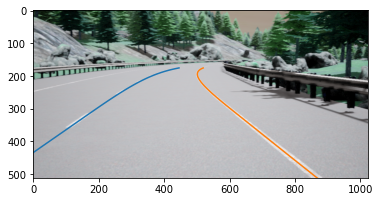

In [40]:
for boundary_polyline in [boundary_gt[:,0:3], boundary_gt[:,3:]]:
    uv = camera_geometry.project_polyline(boundary_polyline, trafo_world_to_cam, K)
    u,v = uv[:,0], uv[:,1]
    plt.plot(u,v)
plt.imshow(image);

## Bonus information
The image above is good, but not in the proper format if we want to use it to train a neural net for image segmentation.
Here, I quickly show you how to get label images in the proper format. You can skip this section if you want.

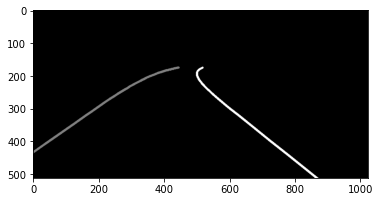

In [41]:
def create_label_img(lb_left, lb_right):
    label = np.zeros((512, 1024, 3))
    colors = [[1, 1, 1], [2, 2, 2]]
    for color, lb in zip(colors, [lb_left, lb_right]):
        cv2.polylines(label, np.int32([lb]), isClosed=False, color=color, thickness=5)
    label = np.mean(label, axis=2)  # collapse color channels to get gray scale
    return label

uv_left = camera_geometry.project_polyline(boundary_gt[:,0:3], trafo_world_to_cam, K)
uv_right = camera_geometry.project_polyline(boundary_gt[:,3:], trafo_world_to_cam, K)

label = create_label_img(uv_left, uv_right)
plt.imshow(label, cmap="gray");
# cv2.imwrite("mylabel.png", label)

Note that matplotlib's imshow rescales the intensity, which is why we can nicely see the lane boundaries here. If you would save the label as a png with `cv2.imwrite()` and would open it in an image viewing program it would look all black. That is because the maximum intensity is 255, and hence 0,1, and 2 all look black. This is not a problem, because the label image is intended for the deep learning model, not the human eye.